In [1]:
!pip install pypdf langchain langchain_core langchain_community langchain_huggingface langchain_groq sentence_transformers transformers langchain_google_genai faiss-cpu langchain_openai grandalf pypdf pinecone langchain_pinecone pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.3/302.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.9/421.9 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.7/126.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1

In [17]:
from langchain_community.document_loaders import PyMuPDFLoader

file_path = "GSTsmartGuide.pdf"
loader = PyMuPDFLoader(file_path)

In [18]:
docs = loader.load()

In [19]:
# import nltk
# import tiktoken
# from sentence_transformers import SentenceTransformer, util
# import numpy as np

# nltk.download('punkt')

# # Initialize tools
# model = SentenceTransformer('all-MiniLM-L6-v2')
# tokenizer = tiktoken.get_encoding("cl100k_base")

# def count_tokens(text):
#     return len(tokenizer.encode(text))

# def split_into_paragraphs(text):
#     return [p.strip() for p in text.split("\n\n") if p.strip()]

# def hybrid_chunking_semantic_fixed_limit(docs, max_tokens=512):
#     # Step 1: Combine all text from the docs
#     full_text = "\n\n".join(doc.page_content for doc in docs if doc.page_content.strip())

#     # Step 2: Paragraph-level split
#     paragraphs = split_into_paragraphs(full_text)

#     # Step 3: Embed all paragraphs
#     embeddings = model.encode(paragraphs, convert_to_tensor=True)

#     # Step 4: Greedy grouping under token limit
#     chunks, current_chunk, current_tokens = [], [], 0

#     for i, para in enumerate(paragraphs):
#         para_tokens = count_tokens(para)
#         if current_tokens + para_tokens <= max_tokens:
#             current_chunk.append(para)
#             current_tokens += para_tokens
#         else:
#             chunks.append(" ".join(current_chunk))
#             current_chunk = [para]
#             current_tokens = para_tokens

#     if current_chunk:
#         chunks.append(" ".join(current_chunk))

#     return chunks

import nltk
import tiktoken
from sentence_transformers import SentenceTransformer, util
import numpy as np

nltk.download('punkt')

# Initialize tools
model = SentenceTransformer('all-MiniLM-L6-v2')
tokenizer = tiktoken.get_encoding("cl100k_base")

def count_tokens(text):
    return len(tokenizer.encode(text))

def split_into_paragraphs(text):
    return [p.strip() for p in text.split("\n\n") if p.strip()]

def hybrid_chunking_semantic_fixed_limit(docs, max_tokens_per_chunk=512):
    """
    Splits documents into semantically meaningful chunks without exceeding the token limit.

    Args:
        docs (list): List of documents with .page_content attribute.
        max_tokens_per_chunk (int): Maximum number of tokens allowed in each chunk.

    Returns:
        list: List of text chunks.
    """

    # Step 1: Combine all text from the docs
    full_text = "\n\n".join(doc.page_content for doc in docs if doc.page_content.strip())

    # Step 2: Paragraph-level split
    paragraphs = split_into_paragraphs(full_text)

    # Step 3: Greedy grouping under token limit
    chunks, current_chunk, current_tokens = [], [], 0

    for para in paragraphs:
        para_tokens = count_tokens(para)

        # If a single paragraph is too big, split it sentence-wise
        if para_tokens > max_tokens_per_chunk:
            sentences = nltk.sent_tokenize(para)
            for sentence in sentences:
                sentence_tokens = count_tokens(sentence)
                if current_tokens + sentence_tokens <= max_tokens_per_chunk:
                    current_chunk.append(sentence)
                    current_tokens += sentence_tokens
                else:
                    chunks.append(" ".join(current_chunk))
                    current_chunk = [sentence]
                    current_tokens = sentence_tokens
        else:
            if current_tokens + para_tokens <= max_tokens_per_chunk:
                current_chunk.append(para)
                current_tokens += para_tokens
            else:
                chunks.append(" ".join(current_chunk))
                current_chunk = [para]
                current_tokens = para_tokens

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    return chunks


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [41]:
hybrid_chunks = hybrid_chunking_semantic_fixed_limit(docs, max_tokens_per_chunk=200)

In [42]:
hybrid_chunks[101]

'Metropolitan Cities are Bengaluru, \nChennai, Delhi NCR (limited to Delhi, Noida, Greater Noida, Ghaziabad, \nGurgaon, and Faridabad), Hyderabad, Kolkata and Mumbai (whole of MMR). 25.32 Conditions for new tax rate: \n(a)  Input tax credit shall not be available \n(b) 80% of inputs and input services [other than capital goods, TDR/JDA, \nFSI, long-term lease (premiums)] shall be purchased from registered \npersons. On shortfall of purchases from 80%, tax shall be paid by the \nbuilder @ 18% on RCM basis. However, Tax on cement purchased from \nunregistered person shall be paid @ 28% under RCM, and on capital \ngoods under RCM at applicable rates.'

In [43]:
len(hybrid_chunks)

4734

In [5]:
# from langchain_text_splitters import RecursiveCharacterTextSplitter
# text_splitter = RecursiveCharacterTextSplitter(
#     # Set a really small chunk size, just to show.
#     chunk_size=300,
#     chunk_overlap=20,
#     length_function=len,
#     is_separator_regex=False,
# )

In [7]:
!pip install -qU langchain-pinecone pinecone-notebooks

In [8]:
import getpass
import os

from pinecone import Pinecone, ServerlessSpec

if not os.getenv("PINECONE_API_KEY"):
    os.environ["PINECONE_API_KEY"] = getpass.getpass("Enter your Pinecone API key: ")

pinecone_api_key = os.environ.get("PINECONE_API_KEY")

pc = Pinecone(api_key=pinecone_api_key)

Enter your Pinecone API key: ··········


In [9]:
import time

index_name = "gstsmartguide"  # change if desired

existing_indexes = [index_info["name"] for index_info in pc.list_indexes()]

if index_name not in existing_indexes:
    pc.create_index(
        name=index_name,
        dimension=384,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1"),
    )
    while not pc.describe_index(index_name).status["ready"]:
        time.sleep(1)

index = pc.Index(index_name)

In [10]:
from langchain_huggingface import HuggingFaceEmbeddings
huggingface_embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [11]:
from langchain_pinecone import PineconeVectorStore

vector_store = PineconeVectorStore(index=index, embedding=huggingface_embeddings)

In [26]:
#formating documents
from langchain.schema import Document

def proper_format(hybrid_chunks, start_page=1):
    docs = []
    for i, chunk in enumerate(hybrid_chunks):
        metadata = {
            "page": start_page + i,  # if you know approximate page mapping
            "chunk_index": i,
            "type": "hybrid"
        }
        doc = Document(page_content=chunk.strip(), metadata=metadata)
        docs.append(doc)
    return docs


In [44]:
documents=proper_format(hybrid_chunks)

In [45]:
len(documents)

4734

In [46]:
documents[102]

Document(metadata={'page': 103, 'chunk_index': 102, 'type': 'hybrid'}, page_content='25.33 GST exemption on TDR/JDA, long term lease (premium), FSI  \nIntermediate tax on development right, such as TDR, JDA, lease (premium), \nFSI shall be exempted only for such residential property on which GST is \npayable. 25.34 The new rate has become applicable from 1-4-2019. 25.35 One time transition option given to real estate firms to continue to pay \ntax at the old rates (effective rate of 8% or 12% with ITC) on on-going projects \n(buildings where construction and actual booking have both started before 1-4-\n2019) which have not been completed by 31-3-2019. Real estate firms can \ncommunicate their option till 20-5-2019 to the jurisdictional officers.')

In [47]:
vector_store.add_documents(documents=documents)

['f1752d2a-23ec-47a1-9a25-a90871232c17',
 '7f1a7589-9a03-4b94-b0d8-af448ea5be13',
 '03d7f25f-9b0b-4590-b834-90e19052eb4e',
 '32932299-769f-4792-9465-a351152188a6',
 'c832456e-e798-4f06-b0bb-cda09885e098',
 '106f011a-7922-4a7c-931c-c4c1182ae894',
 '5ae0cbb9-ba9d-4d08-a7ff-ec0412590fc8',
 'f4a595a2-e0a3-487d-a279-0355d59bc024',
 '9a03c40f-1905-481b-9966-19a89a8e9dfe',
 'cd242353-1e25-44d1-a6ed-3d6fb6eb9785',
 '0a4ba62e-1673-49d9-aa52-6c8788b7cea2',
 '338f526f-8777-49a6-84ab-76fc5825b7ba',
 'fc9bee0f-6161-41e8-b0fb-12b382fc7c08',
 '51ad627f-68ab-4236-83ea-3d6e1fd8320a',
 '10f4ca58-3406-4634-bfbe-05daebfb4cf3',
 '5f94081c-45b7-4e88-8647-b57c36c4b7d3',
 'b7669c4f-2e93-46d8-94bc-fb370bb355b6',
 '984450a0-7521-4a38-9ddf-8e84cf609b12',
 '7c2f03dc-75f6-4d9c-9eb8-ce245a30909c',
 '0d82c55d-8a5d-4d78-b368-ef4d9cfc59c3',
 '163cd77c-1fe5-4a8d-ab29-53ebc9d6fb9b',
 '1301ae20-b0c1-4647-9b1e-bbe6b0cad849',
 '7487ef39-d18f-4180-a13e-38c8b91138c0',
 'a450aed7-7eb9-4271-b860-db3312f98ef3',
 '878e7755-f170-

In [48]:
retriever = vector_store.as_retriever()

In [50]:
result=retriever.get_relevant_documents("what is Limitation for recovery and adjudication")

<ipython-input-50-2169e95ff55f>:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result=retriever.get_relevant_documents("what is Limitation for recovery and adjudication")


In [51]:
result

[Document(id='25bb6706-d2df-4d47-87fd-04b480abc95b', metadata={'chunk_index': 1872.0, 'page': 1873.0, 'type': 'hybrid'}, page_content='\uf0d8 Adjudication proceeding deemed to be concluded beyond time limits \n (10) The adjudication proceedings shall be deemed to be concluded, if the \norder is not issued within 3 years as provided for in sub-section (10) of \nSection 73 or within 5 years as provided for in sub-section (10) of \nSection 74. \uf0d8  Computing period shall be determined by considering the order by the \nAppellate Authority, High Court and Supreme Court shall be excluded.'),
 Document(id='2c0f25f1-61eb-4a4a-9cfd-6eebdaa430c0', metadata={'chunk_index': 2670.0, 'page': 2671.0, 'type': 'hybrid'}, page_content='Time limits for adjudication in cases of normal period of limitation \nAs per Section 73(10) of the CGST Act, 2017, the proper officer is required \nto issue the order within three years from the due date for furnishing of annual \nreturn for the financial year to whic

In [52]:
page_content_list = [doc.page_content for doc in result]

In [53]:
page_content_list

['\uf0d8 Adjudication proceeding deemed to be concluded beyond time limits \n (10) The adjudication proceedings shall be deemed to be concluded, if the \norder is not issued within 3 years as provided for in sub-section (10) of \nSection 73 or within 5 years as provided for in sub-section (10) of \nSection 74. \uf0d8  Computing period shall be determined by considering the order by the \nAppellate Authority, High Court and Supreme Court shall be excluded.',
 'Time limits for adjudication in cases of normal period of limitation \nAs per Section 73(10) of the CGST Act, 2017, the proper officer is required \nto issue the order within three years from the due date for furnishing of annual \nreturn for the financial year to which the tax not paid or short paid or input tax \ncredit wrongly availed or utilised relates to any reason other than fraud or any \nwilful misstatement or suppression of facts. Chap. 29 \nAdjudication Proceeding \n729 \n9.',
 '(8) (a) where in pursuance of an assessme

In [54]:
result=retriever.get_relevant_documents('''Adjudication proceeding should initiated u/s 73 and u/s 74 of the Act by
issuance of show cause notice and pass of Order by the adjudicating Authority
within time limit prescribed as under: ''')

In [55]:
page_content_list = [doc.page_content for doc in result]

In [56]:
page_content_list

['Time limit for adjudication \n Adjudication proceeding should initiated u/s 73 and u/s 74 of the Act by \nissuance of show cause notice and pass of Order by the adjudicating Authority \nwithin time limit prescribed as under:  \nTax Period \nDue date of \nfurnishing An-\nnual return-\nFORM GSTR-9 \nLast date for \nissuance of the \nshow cause \nnotice as per \nS.73 \nLast date for \nissuance of the \nshow cause \nnotice as per \nS.74 \nLast date for \nissuance of \npass of Or-\nder as per \nS.73 \nLast date for \nissuance of \npass of Order \nas per S.74 \n2017-2018 \n05-02-2020 \n07-02-2020 \n30-09-2023 \n05-08-2024 \n07-08-2024 \n31-12-2023 \n05-02-2025 \n07-02-2025 \n2018-2019 \n31-12-2020 \n31-01-2024 \n30-06-2025 \n31-04-2024 \n31-12-2025 \n2019-2020 \n31-03-2021 \n31-05-2024 \n30-09-2025 \n31-08-2024 \n31-03-2026 \n2020-2021 \n28-02-2022 \n30-11-2024 \n31-08-2026 \n28-02-2025 \n28-02-2027 \n2021-2022 \n31-12-2022 \n30-09-2025 \n30-06-2027 \n30-12-2025 \n31-12-2027 \n2022-2023 \n

In [57]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It",api_key="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")

In [58]:
from langchain.prompts import PromptTemplate

prompt_template = PromptTemplate(
    input_variables=["context", "question"],
    template="""
You are a professional legal and tax assistant. Use the following context extracted from a GST reference guide to answer the user’s question as accurately and completely as possible.

If the answer is not found in the context, say “The document does not contain this information.”

-----------------------
Context:
{context}
-----------------------

Question: {question}

Answer:"""


)


In [59]:
from langchain.chains import RetrievalQA

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,  # your Groq LLM instance
    retriever=retriever,
    chain_type="stuff",
    chain_type_kwargs={"prompt": prompt_template}
)

In [69]:
query = '''what is The basic principles of adjudication?'''
result = qa_chain.run(query)

print(result)

Here are the basic principles of adjudication as outlined in the text:

1. **Natural Justice:** Adjudication proceedings must be fair and impartial, adhering to the principles of natural justice. 
2. **Reasonable Time:** The adjudicating authority must provide reasonable time for adjudication, as per statutory provisions and time limits set by the Act.
3. **Adjournments:** Adjournments of personal hearings may be granted for sufficient cause, up to three occasions.  
4. **Quantification and Legal Basis:** The adjudication order must clearly quantify the duty demanded and state the specific legal provisions under which the duty is confirmed and any penalties are imposed.  
5. **De Novo Adjudication:** If a case is remanded for de novo adjudication by an appellate authority, the same authority that originally adjudicated the case should conduct the new proceedings. 
6. **Cross-Examination:** The adjudicating authority should consider requests for cross-examination, taking into account th

output: Markdown Preview

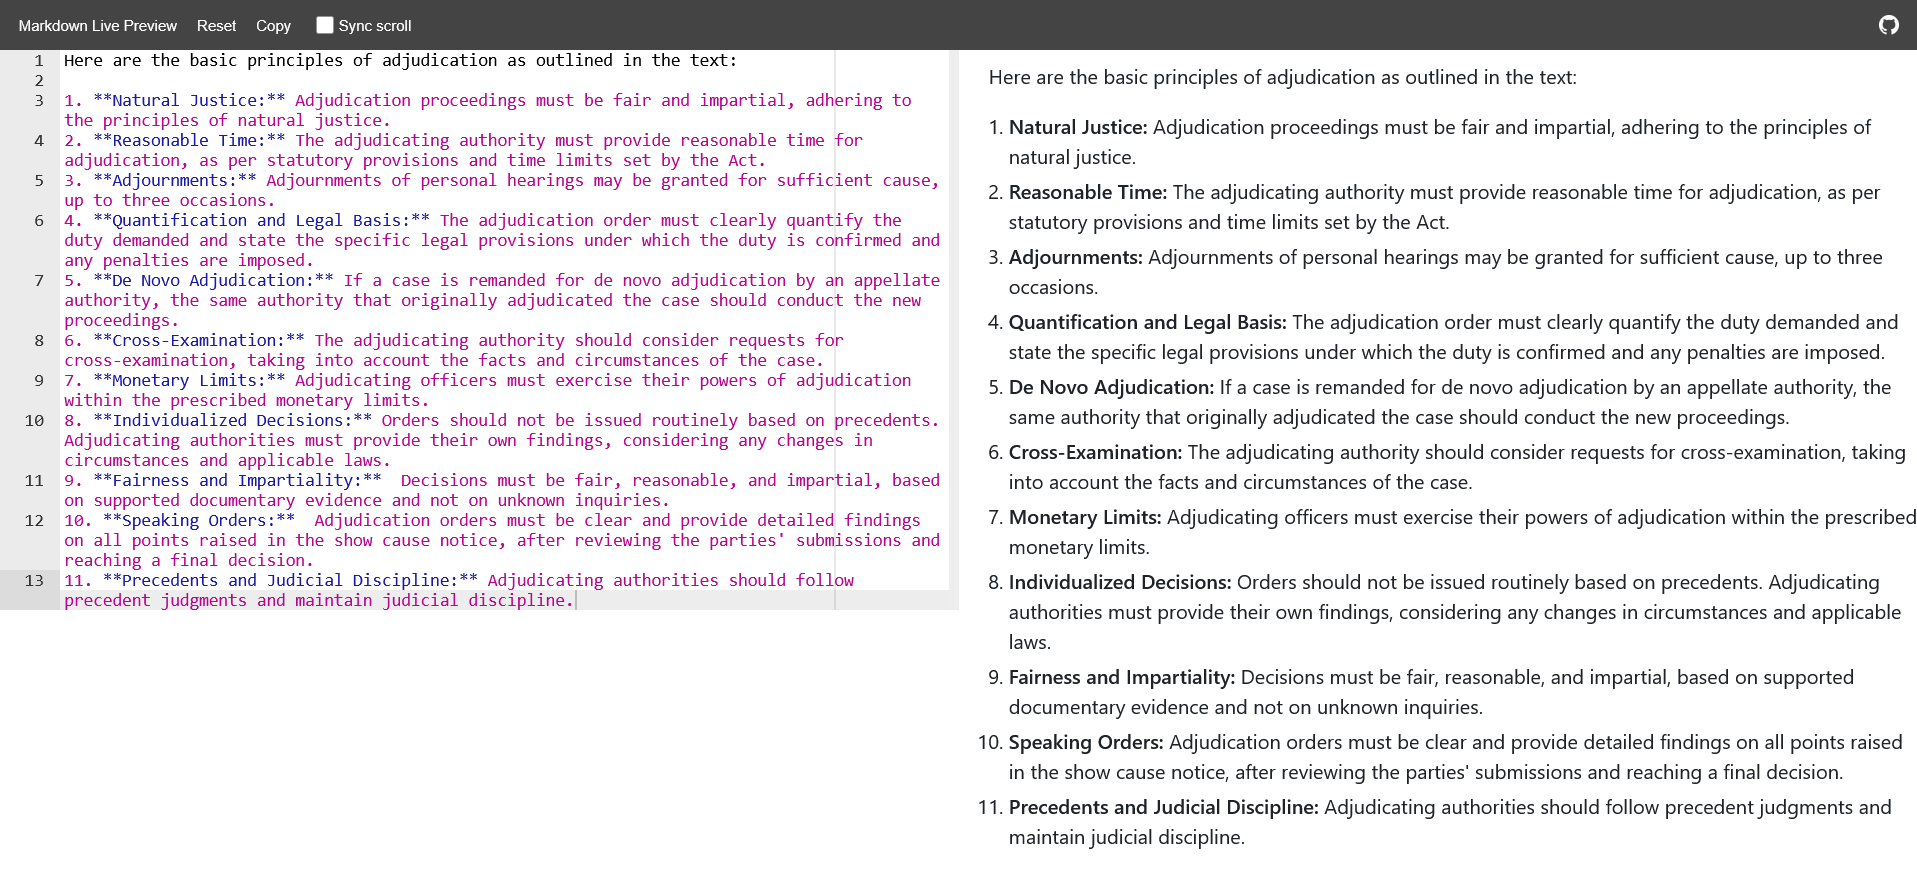